In [2]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.10"):
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.22.4", 'matplotlib': "3.5.2",'sklearn': "1.1.1", 
                'pandas': "1.4.2",'xgboost': "1.5.1", 'shap': "0.40.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.10.5

[ OK ] numpy version 1.22.4 is installed.
[ OK ] matplotlib version 3.5.2 is installed.
[ OK ] sklearn version 1.1.1 is installed.
[ OK ] pandas version 1.4.2 is installed.
[ OK ] xgboost version 1.5.1 is installed.
[ OK ] shap version 0.40.0 is installed.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import linear_model
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import KFold, train_test_split
from datetime import datetime, date
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectKBest,f_regression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

In [4]:
df = pd.read_csv("../data/spotify_prediction_updated_data.csv")
df = df.drop(['Unnamed: 0'], axis=1)
index = df[df['time_signature']==0].index
df.drop(index , inplace=True)

index2 = df[df['release_date'] == '0000'].index
df.drop(index2 , inplace=True)

years = []
for date in df['release_date']:
    years.append(int(date[:4]))
    
df['year'] = years
## Add day, month - see if it affects the models 
df['duration_min'] = df['duration_ms']/60000
df['explicit_flag'] = np.where(df['explicit']==True, 1, 0)

df['recency'] = abs(2022-df['year'])

In [5]:
df.shape

(18551, 29)

In [6]:
df.isnull().any().any()

False

In [ ]:
# release_date_datetime_lst, new_dates, days  = [], [], []

# for str_date in df['release_date']:
#     release_date_datetime_lst = parser.parse(str_date, default=datetime(2021,1,1))
# df['release_date_timestamp'] = release_date_datetime_lst

# for date in df['release_date_datetime']:
#     new_dates.append(date.to_pydatetime()) 
    
# df['release_date_datetime'] = new_dates

# for date in df['release_date_datetime']:
#     days.append(abs((date-date.today()).days))
# df['recency_of_track'] = days

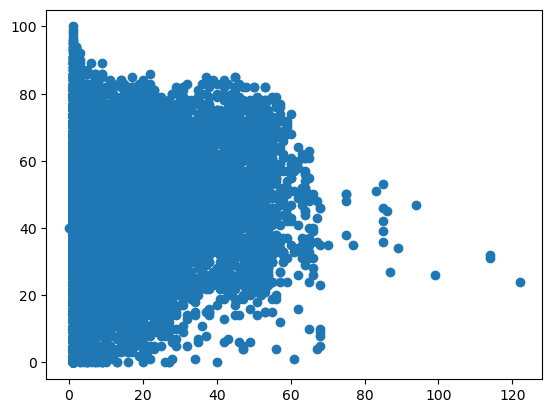

In [7]:
plt.scatter(df['recency'], df['Popularity'])

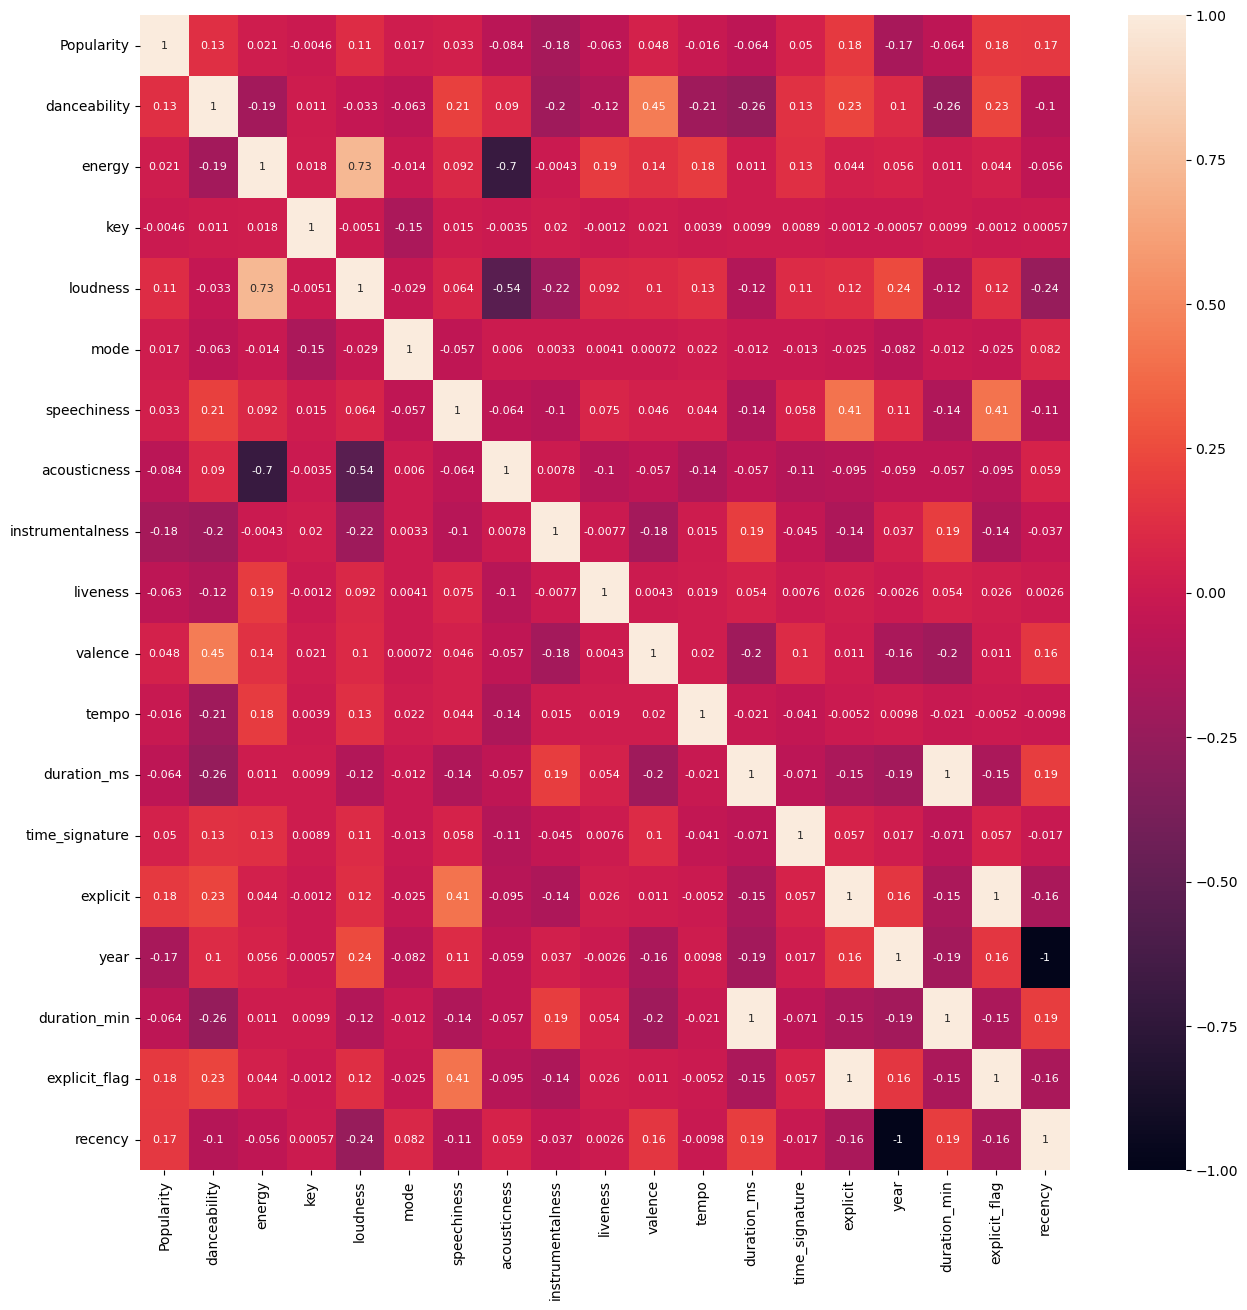

In [41]:
df2 = df.drop(['popularity_as_of_nov26'], axis=1)
plt.figure(figsize = (15,15))
sns.heatmap(df2.corr(), annot=True, annot_kws={"fontsize":8})
plt.savefig('heatmap_of_features.png', format='png', dpi=300)
plt.show()

In [43]:
popularity_corr = df2.corr()
popularity_corr = popularity_corr['Popularity']
popularity_corr

Popularity          1.000000
danceability        0.132482
energy              0.021058
key                -0.004622
loudness            0.112879
mode                0.017235
speechiness         0.032955
acousticness       -0.084381
instrumentalness   -0.178501
liveness           -0.063241
valence             0.048258
tempo              -0.015849
duration_ms        -0.063941
time_signature      0.050496
explicit            0.179264
year               -0.166545
duration_min       -0.063941
explicit_flag       0.179264
recency             0.166545
Name: Popularity, dtype: float64

In [9]:
X = df.drop(['Popularity', 'release_date', 'year', 'duration_ms', 'explicit', 'Artist_Name', 'Genres',
                                    'Track_Name', 
                                    'Playlist', 
                                    'id',
                                    'uri', 
                                    'track_href',
                                    'analysis_url',
                                    'popularity_as_of_nov26'],axis=1)
y = df['Popularity']
X.shape, y.shape

((18551, 15), (18551,))

In [10]:
df[['danceability','energy',  'speechiness', 'acousticness','instrumentalness', 'liveness', 'valence', 'tempo']].describe()

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,18551.000000,18551.000000,18551.000000,18551.000000,18551.000000,18551.000000,18551.000000,18551.000000
mean,0.550703,0.685432,0.086670,0.209838,0.120321,0.199024,0.486355,123.251179
std,0.169134,0.218937,0.090627,0.279467,0.257914,0.159612,0.237153,29.592012
min,0.059900,0.000020,0.022500,0.000000,0.000000,0.011900,0.000000,42.956000
25%,0.436000,0.537000,0.035600,0.003100,0.000001,0.097600,0.301000,99.953000
50%,0.551000,0.716000,0.050300,0.061100,0.000313,0.132000,0.481000,120.996000
75%,0.670000,0.872000,0.092500,0.339000,0.042400,0.265000,0.669000,142.191500
max,0.989000,1.000000,0.960000,0.996000,0.996000,0.992000,0.986000,249.438000


In [11]:
from sklearn.compose import ColumnTransformer as ct
from sklearn.preprocessing import OneHotEncoder as ohe, StandardScaler as ss, MinMaxScaler as mm

oh_vars = ['time_signature', 'key']
ss_vars = ['loudness', 'tempo', 'duration_min','danceability','energy', \
           'speechiness', 'acousticness','instrumentalness', 'liveness', 'valence']
oh_encoder = ohe(sparse=False, handle_unknown = 'ignore') 
ss_encoder = ss()

preprocessor = ct(transformers = [('cat', oh_encoder, oh_vars),
                               ('ss_cont', ss_encoder, ss_vars),
                               ('drop_cols', 'drop', 
          ['loudness', 'tempo', 'time_signature', 
           'key', 'loudness', 'tempo', 'duration_min','danceability','energy', 
           'speechiness', 'acousticness','instrumentalness', 'liveness', 'valence'])],
                                    remainder='passthrough', sparse_threshold=0) 

In [ ]:
# from sklearn.compose import ColumnTransformer as ct
# from sklearn.preprocessing import OneHotEncoder as ohe, StandardScaler as ss, MinMaxScaler as mm

# oh_vars = ['time_signature', 'key']
# ss_vars = ['loudness', 'tempo', 'duration_min']
# # mm_vars = ['danceability','energy', 'speechiness', 'acousticness','instrumentalness', 'liveness', 'valence']
# oh_encoder = ohe(sparse=False, handle_unknown = 'ignore') 
# ss_encoder = ss()
# # mm_encoder = mm(feature_range=(0, 1))

# preprocessor = ct(transformers = [('cat', oh_encoder, oh_vars),
#                                ('ss_cont', ss_encoder, ss_vars),
# #                                ('mm_cont', mm_encoder, mm_vars),
#                                ('drop_cols', 'drop', 
# #                                 ['Artist_Name', 'Genres',
# #                                     'Track_Name', 
# #                                     'Playlist', 
# #                                     'id',
# #                                     'uri', 
# #                                     'track_href',
# #                                     'analysis_url',
# #                                     'popularity_as_of_nov26',
#                                    ['loudness', 'tempo',  
#                                     'time_signature', 
#                                     'key', 
# #                                     'danceability',
# #                                     'energy', 
# #                                     'speechiness', 
# #                                     'acousticness','instrumentalness', 
# #                                     'liveness', 'valence'
#                                                      ])],
#                                     remainder='passthrough', 
#                                sparse_threshold=0) 

In [12]:
df_check = pd.DataFrame(data = preprocessor.fit_transform(X), columns = preprocessor.get_feature_names_out())
df_check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18551 entries, 0 to 18550
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cat__time_signature_1      18551 non-null  float64
 1   cat__time_signature_3      18551 non-null  float64
 2   cat__time_signature_4      18551 non-null  float64
 3   cat__time_signature_5      18551 non-null  float64
 4   cat__key_0                 18551 non-null  float64
 5   cat__key_1                 18551 non-null  float64
 6   cat__key_2                 18551 non-null  float64
 7   cat__key_3                 18551 non-null  float64
 8   cat__key_4                 18551 non-null  float64
 9   cat__key_5                 18551 non-null  float64
 10  cat__key_6                 18551 non-null  float64
 11  cat__key_7                 18551 non-null  float64
 12  cat__key_8                 18551 non-null  float64
 13  cat__key_9                 18551 non-null  flo

# Random Forest Regressor

#### *Grid Search CV*

the pipeline will fit_transform the training set (3 folds), and transform the last fold used as validation
then it will train the ML algorithm on the training set and evaluate it on the validation set
it repeats this step automatically such that each fold will be an evaluation set once

#### *Select K Best with F regression*

The F value in regression is the result of a test where the null hypothesis is that all
of the regression coefficients are equal to zero. In other words, the model has no predictive capability

In [ ]:
import shap
shap.initjs()
param_grid = {'randomforestregressor__n_estimators': [100, 150, 200, 250, 300],
              'randomforestregressor__max_depth': [3,5,7,11], 
              'randomforestregressor__max_features':['sqrt', 'log2', None]
             }
          
nr_states = 3
rf_test_scores = np.zeros(nr_states)
rf_final_models, rf_shap_values = [], []

for i in range(nr_states):
    X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=1030*i)
    y_test_mean = np.full((len(y_test),1), y_test.mean(), dtype=int)
    kf = KFold(n_splits=3,shuffle=True,random_state=1030*i)

    reg = RandomForestRegressor(random_state = 1030*i)             
    pipe = make_pipeline(preprocessor,reg)
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'r2',
                        cv=kf, return_train_score = True, n_jobs=-1, verbose=True) 
    grid.fit(X_other, y_other)
    rf_results = pd.DataFrame(grid.cv_results_)

    print('best model parameters:',grid.best_params_)
    print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
    rf_final_models.append(grid)
    
    # calculate and save the test score
    y_test_pred = rf_final_models[-1].predict(X_test)
    explainer = shap.TreeExplainer(rf_final_models[-1].best_estimator_._final_estimator)
    shap_values = explainer.shap_values(X_other, feature_perturbation='interventional')
    rf_shap_values.append(shap_values)
    rf_test_scores[i] = r2_score(y_test,y_test_pred)
    print("Baseline score = ", r2_score(y_test, y_test_mean))
    print('test score:',rf_test_scores[i], "\n") 

In [ ]:
rf_results.head()

In [ ]:
rf_results.shape

In [ ]:
rf_test_scores

In [ ]:
for grid in rf_final_models:
    print(grid.best_estimator_._final_estimator.feature_importances_, "\n")

In [ ]:
# the blue line made by p1 and p2 is a line that represents perfect regression. 
# The closer the points are to the line, the more accurate the model is. 
# It can also be used to understand if the model is under or over predicting. 
# If points are above the blue line, the model is over predicting while if 
# the points are below the blue line, the model is under predicting. 

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_test_pred, c='crimson')

p1 = max(max(y_test), max(y_test_pred))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
# load JS visualization code to notebook
import shap
shap.initjs()

explainer = shap.TreeExplainer(rf_final_models[0].best_estimator_._final_estimator)
shap_values = explainer.shap_values(X_test, check_additivity=False)

shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)

In [ ]:
print("Test set prediction for index[18] = ", y_test_pred[18]) 
shap.force_plot(explainer.expected_value, shap_values[18], X_test.iloc[18])

In [ ]:
print("Test set prediction for index[300] = ", y_test_pred[300])
shap.force_plot(explainer.expected_value, shap_values[300], X_test.iloc[300]) 

# KNN Regression

In [ ]:
# we will use GridSearchCV and the parameter names need to contain the ML algorithm you want to use
# the parameters of some ML algorithms have the same name and this is how we avoid confusion
param_grid = {'kneighborsregressor__n_neighbors' : [3,5,7,10,15,20,25,30,50],
              'kneighborsregressor__weights' : ['uniform','distance']}
          
nr_states = 3
knn_test_scores = np.zeros(nr_states)
knn_final_models = []

for i in range(nr_states):
    # first split to separate out the test set
    # we will use kfold on other
    X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=42*i)
    y_test_mean = np.full((len(y_test),1), y_test.mean(), dtype=int)

    # splitter for other
    kf = KFold(n_splits=4,shuffle=True,random_state=42*i)

    reg = KNeighborsRegressor() 

    # the pipeline will fit_transform the training set (4 folds), and transform the last fold used as validation
    # then it will train the ML algorithm on the training set and evaluate it on the validation set
    # it repeats this step automatically such that each fold will be an evaluation set once
    pipe = make_pipeline(preprocessor,reg)

    # use GridSearchCV
    # GridSearchCV loops through all parameter combinations and collects the results 
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'r2',
                        cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
    
    # this line actually fits the model on other
    grid.fit(X_other, y_other)
    # save results into a data frame
    knn_results = pd.DataFrame(grid.cv_results_)

    print('best model parameters:',grid.best_params_)
    print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
    # save the model
    knn_final_models.append(grid)
    # calculate and save the test score
    y_test_pred = knn_final_models[-1].predict(X_test)
    knn_test_scores[i] = r2_score(y_test,y_test_pred)
    print("Baseline score = ", r2_score(y_test, y_test_mean))
    print('test score:',knn_test_scores[i], "\n")

In [ ]:
knn_results.head()

In [ ]:
knn_results.shape

In [ ]:
knn_test_scores

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_test_pred, c='crimson')

p1 = max(max(y_test), max(y_test_pred))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# SVM Regressor

In [ ]:
# we will use GridSearchCV and the parameter names need to contain the ML algorithm you want to use
# the parameters of some ML algorithms have the same name and this is how we avoid confusion
param_grid = {'svr__gamma': [1e-3, 1e-1, 1e1, 1e3, 1e5],
              'svr__C': [1e-1, 1e0, 1e1]}
          
nr_states = 5
svr_test_scores = np.zeros(nr_states)
svr_final_models = []

for i in range(nr_states):
    # first split to separate out the test set
    # we will use kfold on other
    X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=42*i)
    y_test_mean = np.full((len(y_test),1), y_test.mean(), dtype=int)

    # splitter for other
    kf = KFold(n_splits=4,shuffle=True,random_state=42*i)

    reg = SVR()

    # the pipeline will fit_transform the training set (4 folds), and transform the last fold used as validation
    # then it will train the ML algorithm on the training set and evaluate it on the validation set
    # it repeats this step automatically such that each fold will be an evaluation set once
    pipe = make_pipeline(preprocessor,reg)

    # use GridSearchCV
    # GridSearchCV loops through all parameter combinations and collects the results 
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'r2',
                        cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
    
    # this line actually fits the model on other
    grid.fit(X_other, y_other)
    # save results into a data frame
    svr_results = pd.DataFrame(grid.cv_results_)

    print('best model parameters:',grid.best_params_)
    print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
    # save the model
    svr_final_models.append(grid)
    # calculate and save the test score
    y_test_pred = svr_final_models[-1].predict(X_test)
    svr_test_scores[i] = r2_score(y_test,y_test_pred)
    print("Baseline score = ", r2_score(y_test, y_test_mean))
    print('test score:',svr_test_scores[i], "\n")

In [ ]:
svr_results.head()

In [ ]:
svr_results.shape

In [ ]:
svr_test_scores

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_test_pred, c='crimson')

p1 = max(max(y_test), max(y_test_pred))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
# load JS visualization code to notebook
import shap
shap.initjs()

preprocessor.fit_transform(X_other)
X_test_prep = preprocessor.transform(X_test)
explainer = shap.KernelExplainer(svr_final_models[0].best_estimator_._final_estimator.predict, X_test_prep)
shap_values = explainer.shap_values(X_test_prep, check_additivity=False)

shap.summary_plot(shap_values, X_test_prep, plot_type="bar", max_display=10)

# XGBRegressor

In [ ]:
import warnings
warnings.filterwarnings("ignore")

param_grid = {"xgbregressor__learning_rate": [0.001, 0.01, 0.1, 0.03, 0.005, 0.05],
               "xgbregressor__n_estimators": [100, 200, 300, 500, 1000, 5000, 10000]}
          
nr_states = 3
xgb_test_scores = np.zeros(nr_states)
xgb_final_models = []

for i in range(nr_states):
    X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=42*i)
    y_test_mean = np.full((len(y_test),1), y_test.mean(), dtype=int)
    kf = KFold(n_splits=4,shuffle=True,random_state=42*i)

    reg = XGBRegressor(random_state = i) 
    pipe = make_pipeline(preprocessor,reg)
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'r2',
                        cv=kf, return_train_score = True, n_jobs=-1, verbose=True)

    grid.fit(X_other, y_other)
    xgb_results = pd.DataFrame(grid.cv_results_)

    print('best model parameters:',grid.best_params_)
    print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
    xgb_final_models.append(grid)
    y_test_pred = xgb_final_models[-1].predict(X_test)
    xgb_test_scores[i] = r2_score(y_test,y_test_pred)
    print("Baseline score = ", r2_score(y_test, y_test_mean))
    print('test score:',xgb_test_scores[i], "\n")

In [ ]:
xgb_results.head()

In [ ]:
xgb_results.shape

In [ ]:
xgb_test_scores

# Code from PS8

In [16]:
def MLpipe_KFold_RMSE(X, y, preprocessor, algo, param_grid):
    
    initial_random_state = 42
    best_scores, best_params, baseline_scores = [], [], []
    rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    for i in range(10):
        
        # Split the data into train, test and validation sets
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, \
                                           shuffle=True, random_state=initial_random_state*i)
        y_test_mean = np.full((len(y_test),1), y_test.mean(), dtype=int)
        kf = KFold(n_splits=4, shuffle = True, random_state=initial_random_state*i)

        # Pre-processing 
        pipe = make_pipeline(preprocessor, algo)

        # Grid Search CV
        grid = GridSearchCV(pipe, param_grid, cv = kf, scoring=rmse, verbose=True, n_jobs=-1)
        grid.fit(X_other, y_other)
        best_params.append(grid.best_params_)
        baseline_scores.append(mean_squared_error(y_test, y_test_mean, squared=False))
        best_scores.append(abs(grid.score(X_test, y_test)))

    best_results_df = pd.DataFrame({'Best_params':best_params, 'Best_scores':best_scores, \
                                    'Baseline':baseline_scores}) 
    return best_results_df

In [17]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')


params = {'params_Ridge' : {'ridge__solver':['sag','saga'],
                            'ridge__alpha':[1,0.1,0.01,0.001,0.0001,100],
                            'ridge__fit_intercept':[True, False]},
          
          'params_RF':{'randomforestregressor__n_estimators': [100, 150, 200, 250, 300],
                       'randomforestregressor__max_depth': [3,5,7,11], 
                       'randomforestregressor__max_features':['sqrt', 'log2', None]},
          
          'params_SVR':{'svr__gamma': [1e-3, 1e-2, 1e-1, 1e1, 1e3, 1e5],
                        'svr__C': [1e-3, 1e-2,1e-1, 1e0, 1e1,1e2, 1e3]},
          
          'params_KNNR':{'kneighborsregressor__n_neighbors': [1,3,5,10,50], 
                         'kneighborsregressor__weights':['uniform', 'distance']},
          
          'params_XGBR':{"xgbregressor__learning_rate": [0.01], 
                         "xgbregressor__max_depth": [1,5,10,30,50]}
         }

models = {'L2':Ridge(),
          'RandomForest':RandomForestRegressor(),
          'SVR':SVR(),
          'KNN_Regression':KNeighborsRegressor(),
          'XGBRegressor':XGBRegressor()
         }

all_dfs = []
for (which_model, model, params) in zip(models.keys(), models.values(), params.values()):
    result_df = MLpipe_KFold_RMSE(X, y, preprocessor, model, params)
    result_df['Model'] = which_model 
    all_dfs.append(result_df)

final_output_df = pd.concat(all_dfs) 

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds for each of 60 candidates, totalling 240 fits
Fitting 4 folds fo

/Users/sarah_prakriti_peters/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/sarah_prakriti_peters/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/sarah_prakriti_peters/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/sarah_prakriti_peters/opt/anaconda3/envs/data1030/lib/python3.10/site-packages

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Fitting 4 folds for each of 5 candidates, totalling 20 fits


/Users/sarah_prakriti_peters/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/sarah_prakriti_peters/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/sarah_prakriti_peters/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/sarah_prakriti_peters/opt/anaconda3/envs/data1030/lib/python3.10/site-packages

Fitting 4 folds for each of 5 candidates, totalling 20 fits


/Users/sarah_prakriti_peters/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/sarah_prakriti_peters/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/sarah_prakriti_peters/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [18]:
final_output_df['diff'] = final_output_df['Baseline']-final_output_df['Best_scores']
final_output_df['Better than Baseline?'] = np.where(final_output_df['diff']>0, "Yes", "No")
final_output_df

,Best_params,Best_scores,Baseline,Model,diff,Better than Baseline?
0,"{'ridge__alpha': 100, 'ridge__fit_intercept': ...",16.441868,17.608003,L2,1.166135,Yes
1,"{'ridge__alpha': 1, 'ridge__fit_intercept': Tr...",16.606858,17.825428,L2,1.218570,Yes
2,"{'ridge__alpha': 0.0001, 'ridge__fit_intercept...",16.431907,17.598275,L2,1.166368,Yes
3,"{'ridge__alpha': 100, 'ridge__fit_intercept': ...",16.159705,17.456664,L2,1.296959,Yes
4,"{'ridge__alpha': 0.0001, 'ridge__fit_intercept...",16.085887,17.483795,L2,1.397909,Yes
5,"{'ridge__alpha': 100, 'ridge__fit_intercept': ...",16.465500,17.576694,L2,1.111194,Yes
6,"{'ridge__alpha': 0.001, 'ridge__fit_intercept'...",16.704570,18.044587,L2,1.340017,Yes
7,"{'ridge__alpha': 0.0001, 'ridge__fit_intercept...",16.442959,17.610398,L2,1.167438,Yes
8,"{'ridge__alpha': 1, 'ridge__fit_intercept': Tr...",16.523488,17.819849,L2,1.296361,Yes
9,"{'ridge__alpha': 0.01, 'ridge__fit_intercept':...",16.560373,17.715612,L2,1.155239,Yes


In [37]:
means, stds = [], []
for model in final_output_df['Model'].unique():
    sub_df = final_output_df[final_output_df['Model']==model]
    means.append(sub_df['Best_scores'].mean())
    stds.append(np.std(sub_df['Best_scores'])) 

mean_and_std_output = pd.DataFrame({'Model':final_output_df['Model'].unique(), \
                                    'Mean':means,
                                    'Std_Dev':stds})

mean_and_std_output.sort_values(by="Mean", ascending=True) 

,Model,Mean,Std_Dev
1,RandomForest,15.842909,0.171342
2,SVR,15.980386,0.184672
3,KNN_Regression,16.246851,0.188646
0,L2,16.442311,0.179982
4,XGBRegressor,22.839320,0.174694


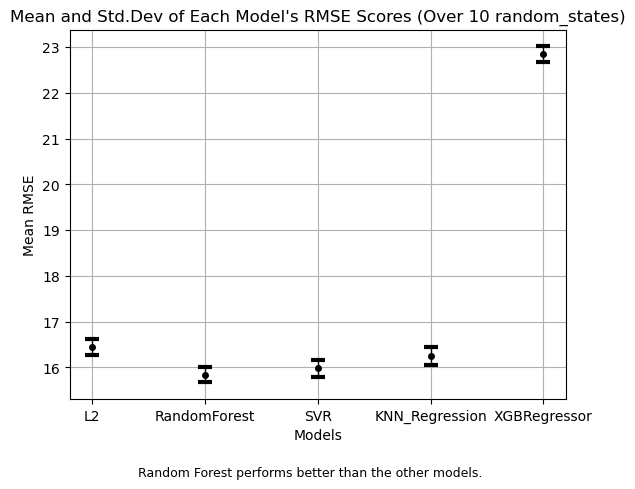

In [38]:
# plot_results = plot_df.iloc[:-2]
# mean_and_std_output = mean_and_std_output[mean_and_std_output['Model']!='XGBRegressor']
plt.errorbar(mean_and_std_output['Model'], mean_and_std_output['Mean'], yerr=mean_and_std_output['Std_Dev'], \
             fmt='o', color='Black', elinewidth=1,capthick=3,errorevery=1, alpha=1, ms=4, capsize = 5)
plt.title("Mean and Std.Dev of Each Model's RMSE Scores (Over 10 random_states)")
plt.xlabel("Models")
plt.ylabel("Mean RMSE")
txt="Random Forest performs better than the other models."
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.grid()
# plt.savefig('rmse_error_bar_of_models.png', format='png', dpi=300)
plt.show()

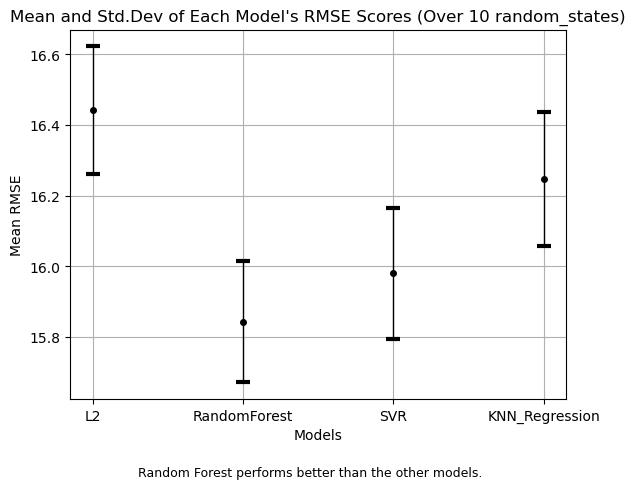

In [35]:
# plot_results = plot_df.iloc[:-2]
mean_and_std_output = mean_and_std_output[mean_and_std_output['Model']!='XGBRegressor']
plt.errorbar(mean_and_std_output['Model'], mean_and_std_output['Mean'], yerr=mean_and_std_output['Std_Dev'], \
             fmt='o', color='Black', elinewidth=1,capthick=3,errorevery=1, alpha=1, ms=4, capsize = 5)
plt.title("Mean and Std.Dev of Each Model's RMSE Scores (Over 10 random_states)")
plt.xlabel("Models")
plt.ylabel("Mean RMSE")
txt="Random Forest performs better than the other models."
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=9)
plt.grid()
plt.savefig('rmse_error_bar_of_models.png', format='png', dpi=300)
plt.show()

In [32]:
final_output_df.to_csv("all_5_models_rmse_output.csv")

# Questions

Walk through the main Grid search CV code and see if that's okay 

1. Should I use select k best with f regression?
2. RMSE vs R^2?
3. Can I use recency instead of years?
4. Should I include the scatter plot of true vs predicted results?
5. Is the shap plot okay? 